# **PARAMETER FITTING DETAILED EXAMPLE**

This provides a detailed example of parameter fitting using the python-based tool ``SBstoat``. 
Details about the tool can be found at in this [github repository](https://github.com/sys-bio/SBstoat).

# Preliminaries

In [1]:
!pip install -q SBstoat
!pip install -q tellurium

In [2]:
# Python packages used in this chapter
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request # use this library to download file from GitHub
import tellurium as te
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter
import SBstoat

# Helpers

In [3]:
TEST_MODEL = """
A->B; A
B->; k*B; 
A = 10; 
B=0
k = 2
"""
rr = te.loada(TEST_MODEL)
TEST_MODEL_ARR = rr.simulate()

In [4]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
rr = te.loada(TEST_MODEL)
data = rr.simulate()
assert(isinstance(arrToDF(data), pd.DataFrame))
print("OK!")

OK!


In [5]:
def generateNoisyData(model, std, parameter_dct=None):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    model: str (Antimony model)
    std: float (standard deviation of generated noise)
    parameter_dct: dict (parameters to change)
    
    Returns
    ------
    SBstoat.NamedTimeseries
    """
    if parameter_dct is None:
        parameter_dct = {}
        #
    rr = te.loada(model)
    for key, value in parameter_dct.items():
        rr[key] = value
    df = arrToDF(rr.simulate())
    ser = df.mean()
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, 0.2, len(noise_df))
        noise_df[column] = ser.loc[column]*noise_arr 
    return SBstoat.NamedTimeseries(dataframe=noise_df + df)

# Tests
timeseries = generateNoisyData(TEST_MODEL, 0, parameter_dct={"k": 3})
assert(isinstance(timeseries, SBstoat.NamedTimeseries))
assert(len(timeseries) > 0)
print("OK!")

OK!


In [6]:
def arrToTS(arr):
    """
    Converts NamedArray to a NamedTimeseries
    
    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    NamedTimeseries
    """
    return SBstoat.NamedTimeseries(array=arr, colnames=arr.colnames)

# Tests
assert(isinstance(arrToTS(TEST_MODEL_ARR), SBstoat.NamedTimeseries))
print("OK!")

OK!


In [7]:
def getParameterValueDct(model):
    """
    Finds the name and value of all parameters.
    
    Parameters
    ----------
    model: str (Antimony model)
    
    Returns
    -------
    dict (key: str, value: float)
    """
    rr = te.loada(model)
    return {n: rr[n] for n in rr.model.getGlobalParameterIds()}

# Tests
dct = getParameterValueDct(TEST_MODEL)
assert(isinstance(dct, dict))
assert("k" in dct.keys())
print("OK!")

OK!


In [8]:
FitterInfo = collections.namedtuple("FitterInfo", "rssq num_eval fitter max_err median_err")

def getFitterInfo(fitter):
    """
    Calculates statistics for the accuracy of a fit.
    
    Parameters
    ----------
    fitter: SBstoat.ModelFitter
    
    Returns
    -------
    FitterInfo
    """
    df = (fitter.residualsTS.to_dataframe()**2)
    rssq = df.sum().sum()
    # Find the number of function evaluations
    report_stg = fitter.reportFit()
    pos = report_stg.index("function evals")
    stg = report_stg[pos:]
    start_pos = stg.index("=") + 1
    end_pos = stg.index("\n")
    num_eval = int(stg[start_pos:end_pos])
    # Get statistics on the fit
    fitter.roadrunnerModel.resetAll()
    parameter_value_dct = getParameterValueDct(fitter.roadrunnerModel.getAntimony())
    errs = []
    for key, value in fitter.params.valuesdict().items():
        err = np.abs(value - parameter_value_dct[key])/parameter_value_dct[key]
        errs.append(err)
    max_err = max(errs)
    median_err = np.median(errs)
    #
    return FitterInfo(rssq=rssq, num_eval=num_eval, fitter=fitter, max_err=max_err, median_err=median_err)
    

# Tests
test_model_ts = arrToTS(TEST_MODEL_ARR)
fitter = SBstoat.ModelFitter(TEST_MODEL, test_model_ts, parametersToFit=[SBstoat.Parameter("k", lower=1, value=1, upper=4)])
fitter.fitModel()
fitter_info = getFitterInfo(fitter)
assert(np.isclose(fitter_info.rssq, 0))
assert(fitter_info.num_eval < 10)
print("OK!")

OK!


# Fitting with SBstoat

``SBstoat`` is a python package intended to simplify the programmatic aspects of fitting. The package provides handles the programming details
of the interactions between the optimization codes (``lmfit``) and ``tellurium`` simulations.

The required inputs to ``SBstoat`` are:
- the model for which parameter values are being estimated;
- observational data; and
- specification of the parameters, their value ranges, and initial values.

For the linear pathway model, we ``LINEAR_PATHWAY_MODEL`` and ``LINEAR_PATHWAY_DF`` for the model and data, respectively.
The description of the paarameters is done using a python dictionary, as shown below.

In [9]:
MODEL2 = """
R1:  S1 -> S2; k1*S1  
R2: S2 + S1 -> S3; k2*S2*S1
R3: S3 -> S4 + S1; k3*S3
R4: S4 + S1 -> S5; k4*S4

S1 = 10

// Parameters
k1 = 1;
k2 = 2;
k3 = 3;
k4 = 4;
"""

## Parameters

In [10]:
# Get the values of parameters in a model
getParameterValueDct(MODEL2)

{'k1': 1.0, 'k2': 2.0, 'k3': 3.0, 'k4': 4.0}

In [11]:
# Name, minimal value, initial value, and maximum value of each parameter
PARAMETERS = [
    SBstoat.Parameter("k1", lower=1, value=5, upper=10),
    SBstoat.Parameter("k2", lower=1, value=5, upper=10),
    SBstoat.Parameter("k3", lower=1, value=5, upper=10),
    SBstoat.Parameter("k4", lower=1, value=5, upper=10),
]

In [12]:
# Construct SBstoat.Parameters by specifying a range relative to "true" values
def makeParameters(model, lower_frc, value_frc, upper_frc):
    """
    Creates SBstoat parameters as a fraction of their true value.
    """
    parameter_value_dct = getParameterValueDct(model)
    parameters = []
    for parameter_name, value in parameter_value_dct.items():
        lower = value*lower_frc
        """  Fill this in
        value = ...
        upper = ...
        parameter = ...
        parameters.append(parameter)
        """
    return parameters

# Tests

## Observational Data

<AxesSubplot:xlabel='time'>

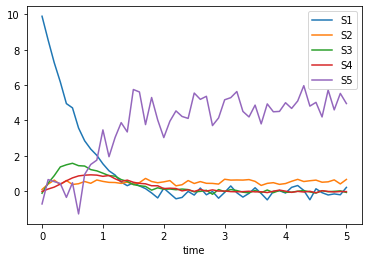

In [28]:
# Generate synthetic data
parameter_value_dct = getParameterValueDct(MODEL2)
OBSERVED_TS = generateNoisyData(MODEL2, 0.2, parameter_dct=parameter_value_dct)
OBSERVED_TS.to_dataframe().plot()

## Running a fit

In [14]:
fitter1 = ModelFitter(MODEL2, OBSERVED_TS, parametersToFit=PARAMETERS,
                    fitterMethods=["differential_evolution"])
fitter1.fitModel()
print(fitter1.reportFit())

[[Variables]]
    k1:  1.0
    k2:  1.8011807726928355
    k3:  3.3046117448751073
    k4:  4.7464355821421815
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1075
    # data points      = 255
    # variables        = 4
    chi-square         = 32.1291526
    reduced chi-square = 0.12800459
    Akaike info crit   = -520.232435
    Bayesian info crit = -506.067381
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.


The report is in three sections.

The first section contains measures of the fit quality. The most commonly used measures are chi-square and reduced chai-square.
We want both of these to be "small", although small is relative.
These measures are most useful when comparing different fit results.

The "Variables" section gives parameter estimates. We se that the estimates obtained are fairly close to
the true values in the original models.

The final section provides information about the relationships between parameter estimates. This can be useful
in models where the structure of the model makes it difficult to separate one parameter from another.
In these cases, there will be a large correlation between parameter (absolute) parameter values.

In [15]:
fitter2 = ModelFitter(MODEL2, OBSERVED_TS, parametersToFit=PARAMETERS,
                    fitterMethods=["leastsquares"])
fitter2.fitModel()
print(fitter2.reportFit())

[[Variables]]
    k1:  1.0000000185040463
    k2:  1.8005747403269363
    k3:  3.3062317061224826
    k4:  4.741941008028923
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 255
    # variables        = 4
    chi-square         = 32.1291392
    reduced chi-square = 0.12800454
    Akaike info crit   = -520.232542
    Bayesian info crit = -506.067487
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.292
    C(k1, k4) =  0.262
    C(k2, k3) = -0.176
    C(k1, k3) =  0.166


## More detailed analyses of fits

``SBstoat`` provides many plots to aid in understanding the fitting results.
You can see these by typing in a Jupyter code cell ``fitter.pl`` and then pressing the tab key.
Arguably the most useful is ``plotFitAll``, which, for each floating species (column in observed data), plots the fitted and observed values.
This is shown below.

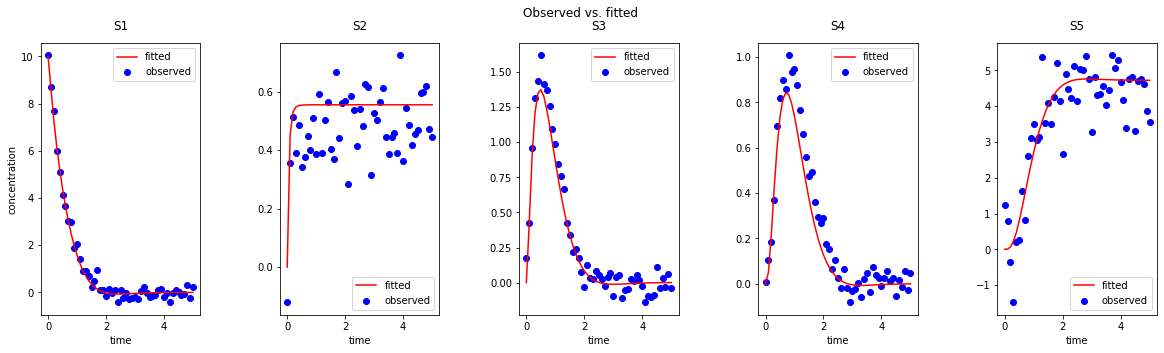

In [16]:
fitter1.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"], titlePosition=(0.5, 1.05))

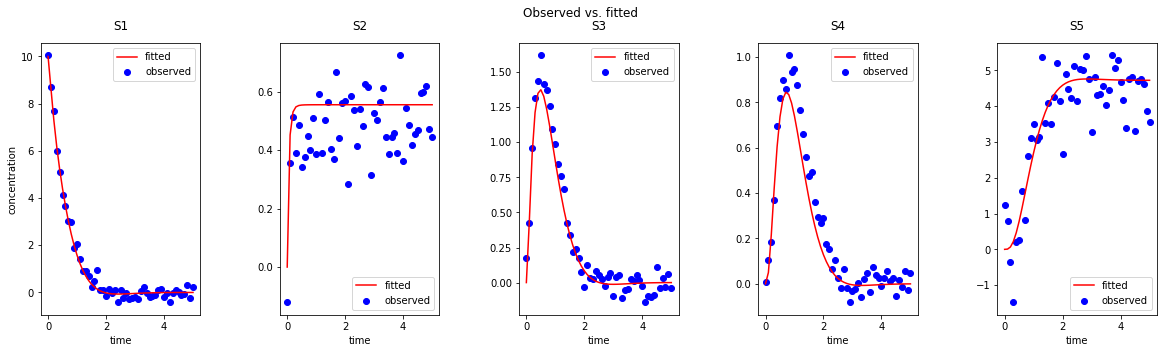

In [17]:
fitter2.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"], titlePosition=(0.5, 1.05))

In [18]:
# See the options for plotFitAll
?fitter1.plotFitAll

Signature:
fitter1.plotFitAll(
    params:lmfit.parameter.Parameters=None,
    numPoint:int=None,
    **kwargs,
)
Docstring:
Plots the fitted with observed data over time.

Parameters
----------

A figure may contain 1 or more plot, and each plot may contain
1 or more line. Figure (f), plot (p), and line (c) are the possible
scope of an option.  If the option is singled valued, then it applies
to all instances of its scope. If it has multiple values, then the
index of the value corresponds to the instance within the scope.
A figure scope is always single valued.
        color: str
    (l) color of the line
    default = blue
columns: list
    (f) List of columns to plot
    default = []
legend: list
    (f) Tuple of str for legend
linestyle: str
    (l) Line style
marker: str
    (l) Marker for line
markersize: float
    (l) Size of marker for the line; >0
numCol: int
    (f) columns of plots
numRow: int
    (f) rows of plots
subplotWidthSpace: float
    (f) horizontal space between pl

If you are interested in a more complete analysis of the residuals, use ``plotResidualsAll``.

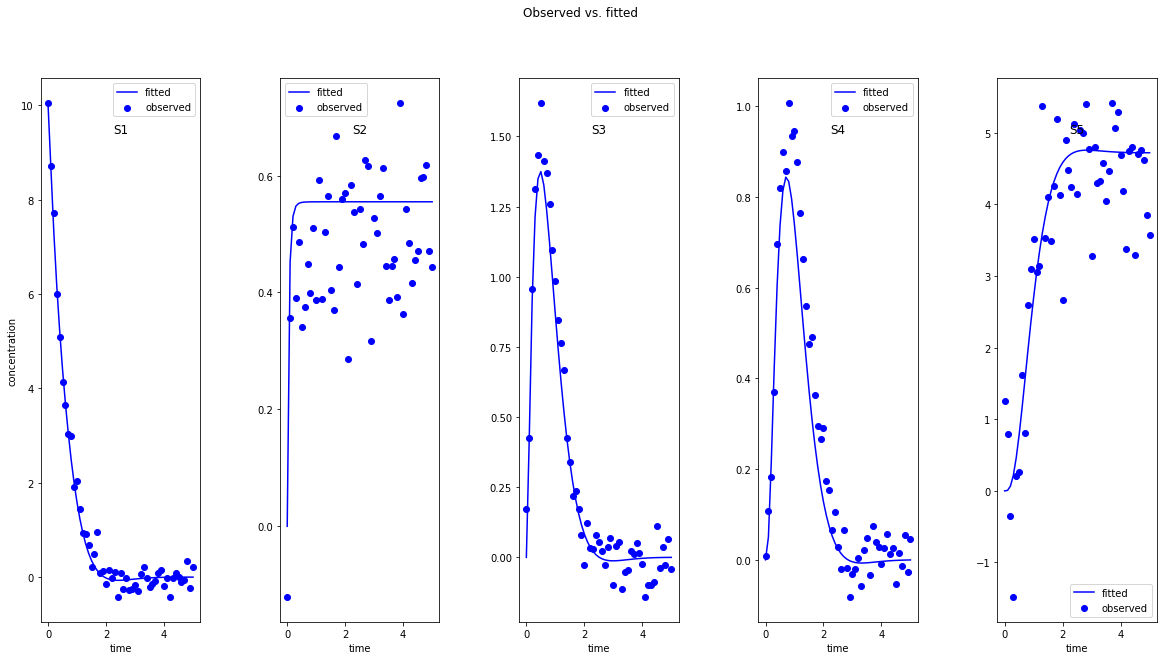

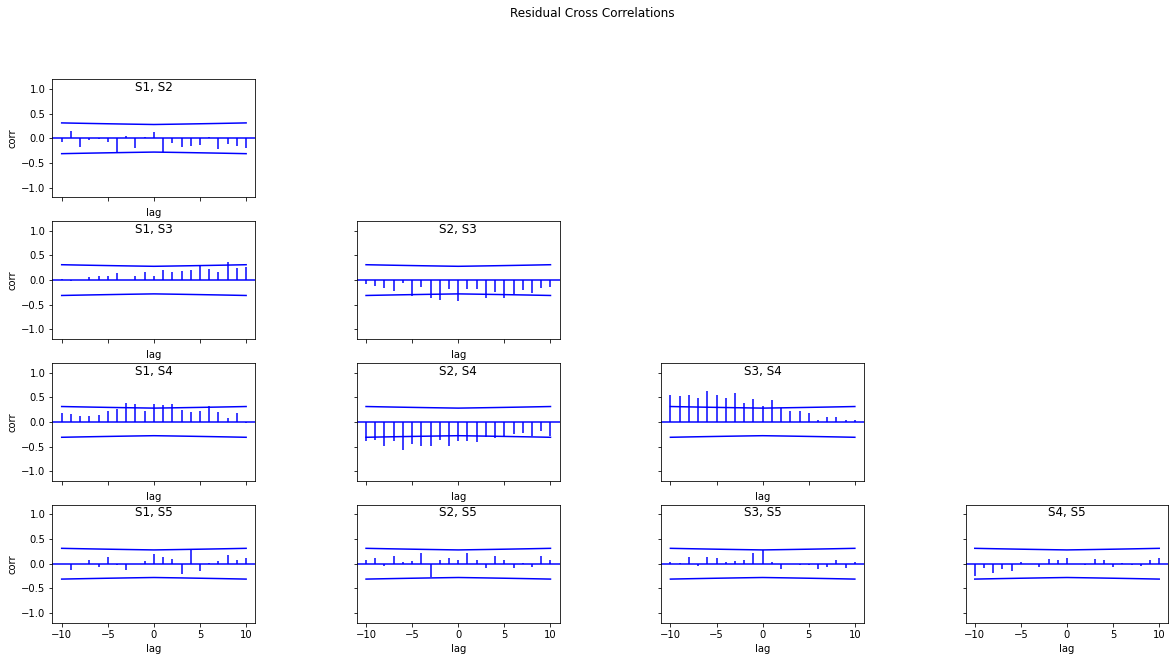

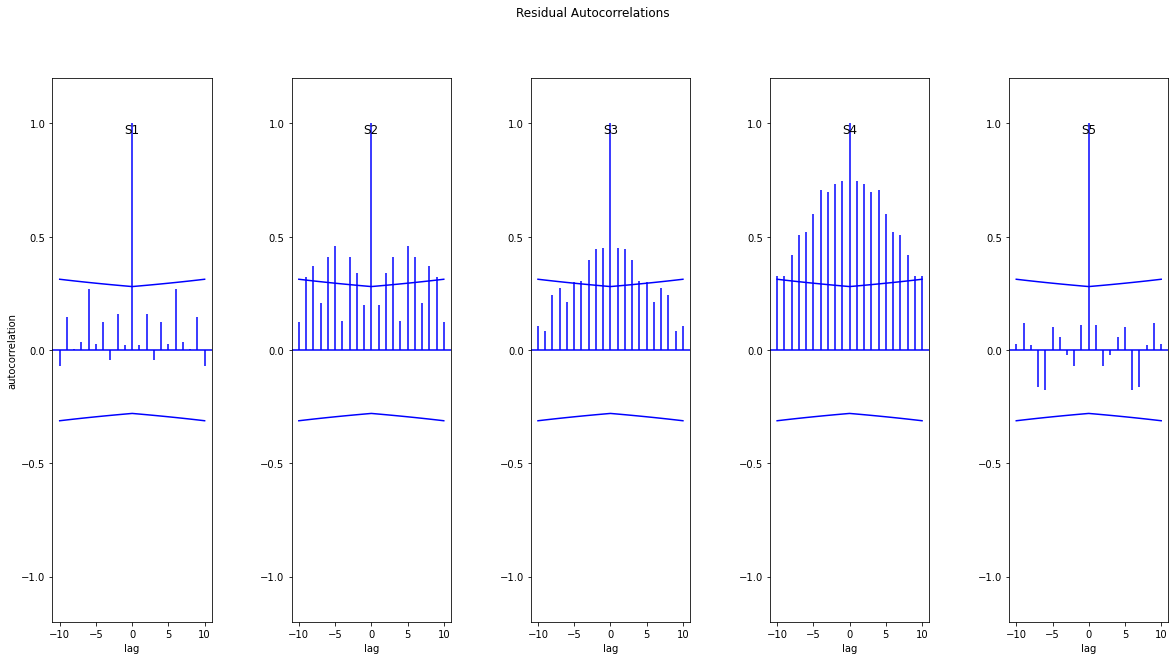

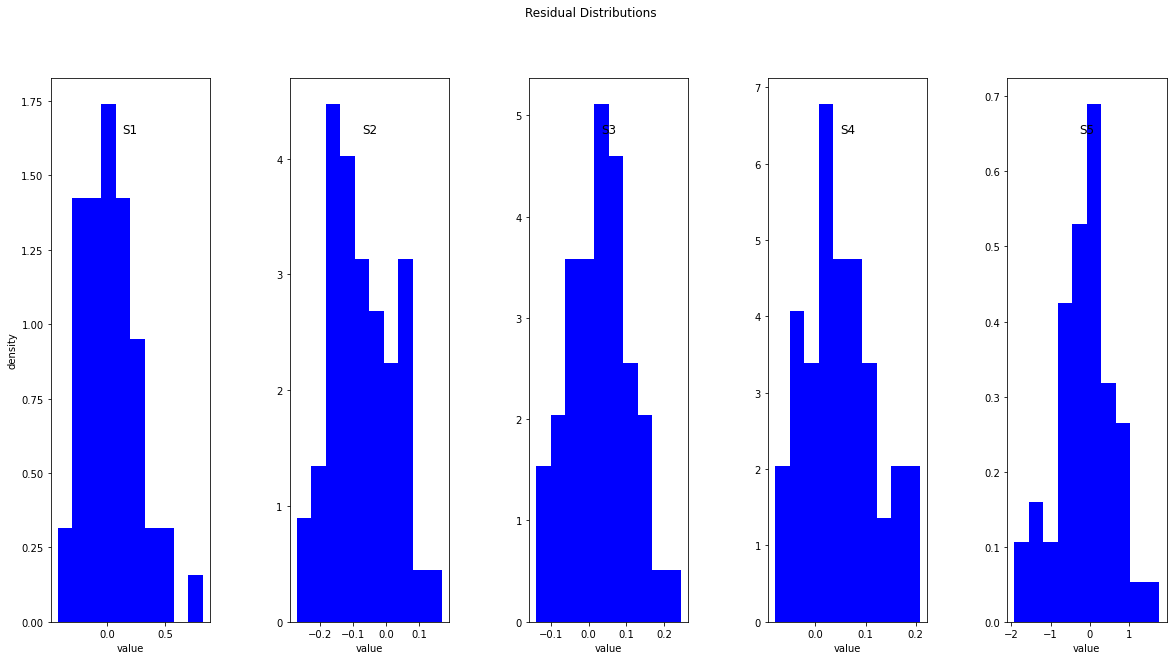

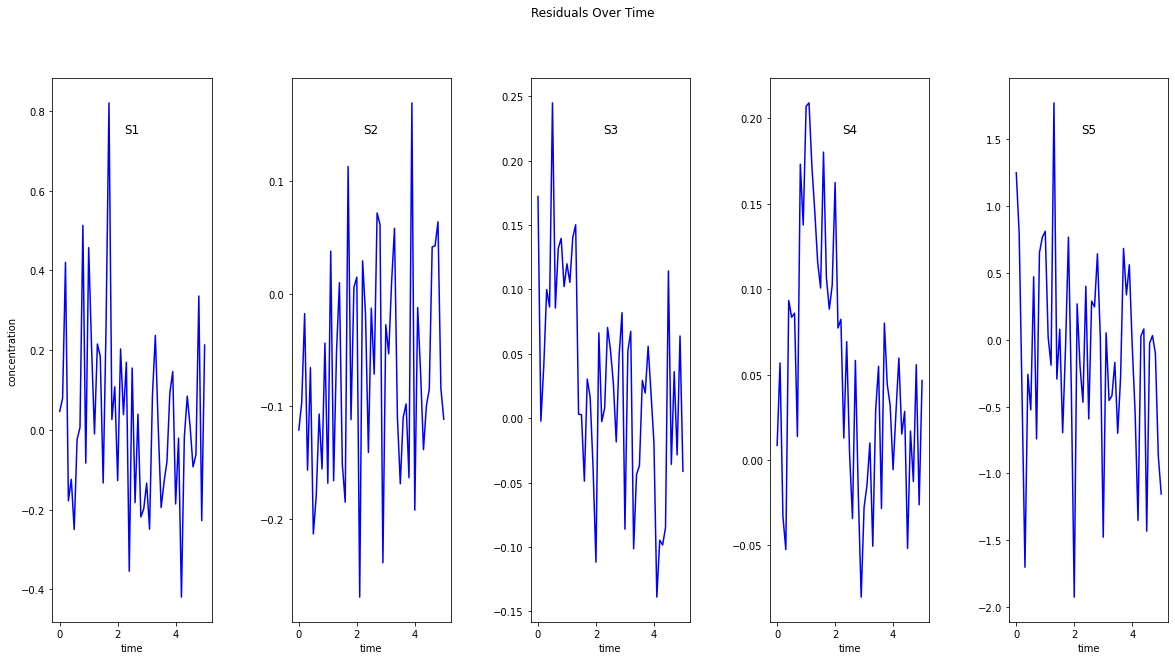

In [19]:
fitter1.plotResidualsAll(figsize=(20, 10))

# Workflow for fitting the Linear Pathway Model

Although ``SBstoat`` eliminates the burden of programming details, fitting is often complex.
This is because of the complexity of the fitting surface, as illustrated earlier in this chaper.
This section illustrates how to use ``SBstoat`` to explore complex fitting surfaces.

``SBstoat`` allows you to explore fitting along three dimensions.
1. **Optimization Algorithms**. As we noted previously, gradient descent is fast, but it only works well for convex fitting surfaces. We might want to try both gradient descent and differential evolution to see which works best for our model. Also, some optimization algorithms are stochastic, and so the search strategy may also choose to run
the same algorithm multiple times. Finally, it may be desirable to do multiple optimizations in succession, using the results of the $n-1$-st to be the starting point for the $n$-th.
1. **Search start** This refers to the initial values of parameter values.
1. **Search scope** This referes to the range of parameter values that are explored.


In the following explorations of the above dimensions of parameter fitting, we use the above workflow that consists of:
1. Select a subset of the observed data based on a specified time span (in this case, just ending time)
1. Construct a fitter for the linear pathway, observed data, columns to consider in fitting, the fitting methods, and parameter ranges/initial values.
1. Fit the model.
1. Print the fitting report.
1. Plot observed and fitted values.

This workflow is encapsulated in the the function ``doFit``.
The arguments of the function have default that reproduce the
results in the previous section.

In [35]:
def doFit(model=MODEL2,
          observed_ts=OBSERVED_TS,
          method="leastsq", 
          parameters=PARAMETERS,
          is_report=True):
    """
    Encapsulates the workflow to fit the linear pathway model.

    Parameters
    ----------
    model: str (antimony model)
    observed_ts: SBstoat.Timeseries
    fitter_methods: str ("leastsq" or "differential_evolution")
    parameterst: list-SBstoat.Parameter
    is_report: bool
        print a report

    Returns
    -------
    FitterInfo
    """
    # Construct the fitter and do the fit
    fitter = ModelFitter(model, observed_ts,
                         fitterMethods=[method], 
                         parametersToFit=parameters)
    fitter.fitModel()
    if is_report:
        print(fitter.reportFit())
        fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],
                          titlePosition=(0.5, 1.05))
    return getFitterInfo(fitter)

# TESTS
fitter_info = doFit(is_report=False, method="differential_evolution")
assert(isinstance(fitter_info, FitterInfo))
print("OK")

OK


## Optimization Algorithms

The main consideration here is the choice of optimization algorithms.
Any valid ``method`` for ``lmfit`` can be used, and multiple methods can be used in combination. We illustrate this below.

[[Variables]]
    k1:  1.0240241388612532
    k2:  1.9851509963397953
    k3:  2.8734782503618854
    k4:  3.869255259860349
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 255
    # variables        = 4
    chi-square         = 31.9519318
    reduced chi-square = 0.12729853
    Akaike info crit   = -521.642880
    Bayesian info crit = -507.477826
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k4) = -0.296
    C(k3, k4) = -0.294
    C(k2, k3) = -0.181
    C(k1, k3) = -0.154


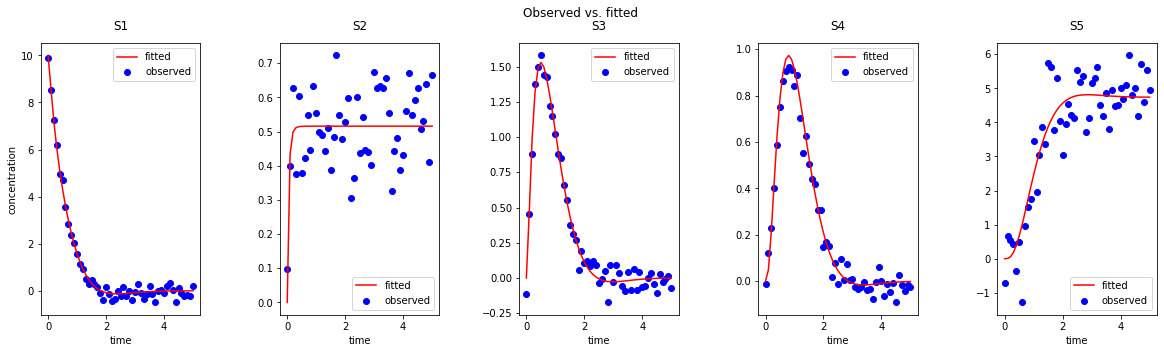

FitterInfo(rssq=31.951931844879997, num_eval=39, fitter=<SBstoat.modelFitter.ModelFitter object at 0x7f6ec700d5c0>, max_err=0.04217391654603819, median_err=0.028355161948082963)

In [36]:
# Fit with Levenberg-Marquardt 
doFit(method="leastsq")

[[Variables]]
    k1:  1.0239982338472369
    k2:  1.9853835141820764
    k3:  2.8733256339759485
    k4:  3.8708891434576556
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1055
    # data points      = 255
    # variables        = 4
    chi-square         = 31.9519322
    reduced chi-square = 0.12729853
    Akaike info crit   = -521.642877
    Bayesian info crit = -507.477823
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.


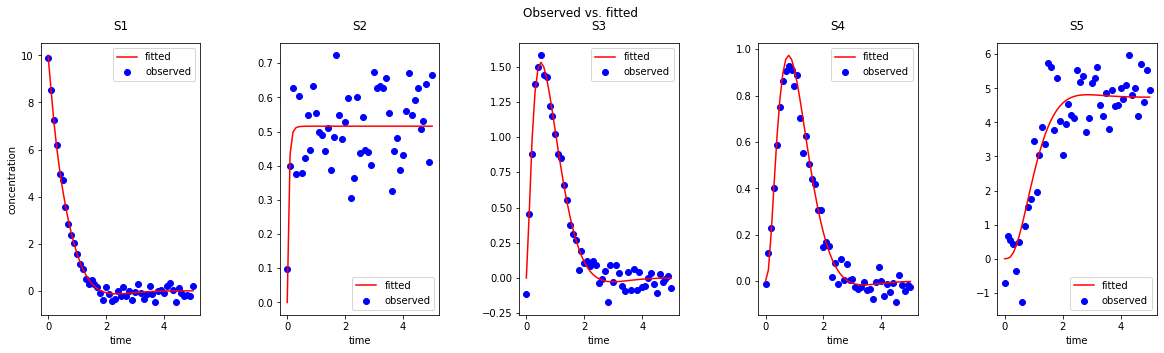

FitterInfo(rssq=31.95193204989728, num_eval=1055, fitter=<SBstoat.modelFitter.ModelFitter object at 0x7f6f353d0b00>, max_err=0.04222478867468382, median_err=0.02813797399141149)

In [37]:
# Fit with differential evolution
doFit(method="differential_evolution")

Observe that for this model, the two algorithms produce the same results. However, the runtime for differential evolution is much longer.

## Search Start & Scope

Where we start the search and how far we search depends on the ranges of parameter values and the specification of initial values.
This is specified by the ``parameterDct`` argument to ``ModelFitter``. This argument defaults to ``LINEAR_PATHWAY_PARAMETER_DCT``.

If we create a bad parameter range, then we get very poor fits. Below, we start the search with a negative value for each parameter.
Note that the observed values appear to be constant because of the large scale of the fitted values.

[[Variables]]
    k1:  -1
    k2:  -1
    k3:  -1
    k4:  -1
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 255
    # variables        = 4
    chi-square         = 2.3494e+12
    reduced chi-square = 9.3602e+09
    Akaike info crit   = 5858.69931
    Bayesian info crit = 5872.86436
[[Correlations]] (unreported correlations are < 0.100)
    C(k2, k3) = -0.824
    C(k3, k4) = -0.819
    C(k1, k3) = -0.779
    C(k1, k2) =  0.659
    C(k2, k4) =  0.636
    C(k1, k4) =  0.281


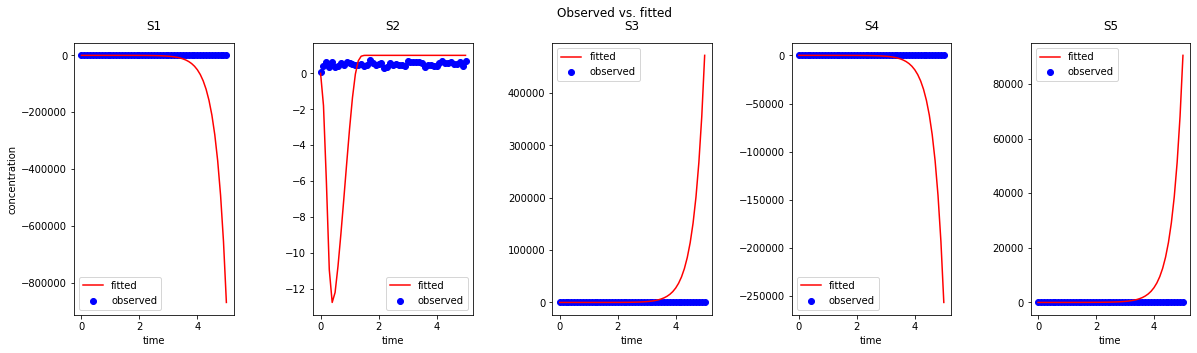

FitterInfo(rssq=2424223647005.214, num_eval=22, fitter=<SBstoat.modelFitter.ModelFitter object at 0x7f6ec6bbdda0>, max_err=2.0, median_err=1.4166666666666665)

In [38]:
parameters = [
    SBstoat.Parameter("k1", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k2", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k3", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k4", lower=-11, value=-1, upper=1),
    ]
doFit(parameters=parameters)

[[Variables]]
    k1:  1.0239114765367274
    k2:  1.9893323606802975
    k3:  2.8713373409487852
    k4:  3.8695134591285276
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 255
    # variables        = 4
    chi-square         = 31.9520143
    reduced chi-square = 0.12729886
    Akaike info crit   = -521.642222
    Bayesian info crit = -507.477168
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.294
    C(k1, k4) = -0.291
    C(k2, k3) = -0.181
    C(k1, k3) = -0.154


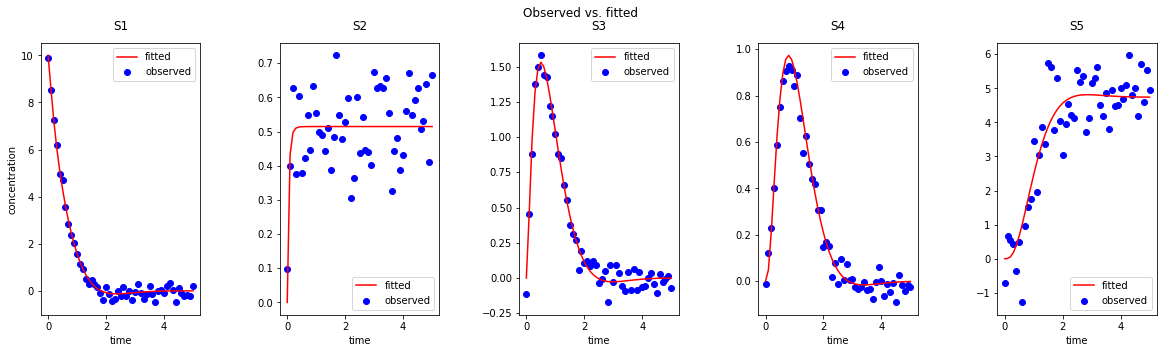

FitterInfo(rssq=31.95201429727769, num_eval=38, fitter=<SBstoat.modelFitter.ModelFitter object at 0x7f6ec70c40f0>, max_err=0.04288755301707159, median_err=0.02826655587729776)

In [42]:
parameters = [
    SBstoat.Parameter("k1", lower=1, value=1, upper=1000),
    SBstoat.Parameter("k2", lower=1, value=1, upper=1000),
    SBstoat.Parameter("k3", lower=1, value=1, upper=1000),
    SBstoat.Parameter("k4", lower=1, value=1, upper=1000),
    ]
doFit(parameters=parameters, method="leastsq")

# Exercise

This exercise is about fitting parameters in the Wolf model for glycolytic oscillations.
The model is ``WOLF_MODEL`` and the observational data for this model are ``WOLF_DF``.

1. Get the WOLF model (691)
1. Create noisy data that will be used as observational data
1. Implement a ``doFit`` function that encapsulates the workflow for the Wolf model.
1. Create SBstoat.Parameters for WOLF
1. Do a fit on the noisy data

In [43]:
wolf_rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000691.3?filename=BIOMD0000000691_url.xml")
print(wolf_rr.getAntimony())

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function function_for_v2(k2, S2, N1)
  k2*S2*N1;
end

function_for_v2 is "function for v2"

function function_for_d_dt_S4_ex(phi, J1, J2)
  (phi/2)*(J1 + J2);
end

function_for_d_dt_S4_ex is "function for d/dt(S4_ex)"

function function_for_v1(k1, S1, A3, K_I, q)
  k1*S1*A3*(1 + (A3/K_I)^q)^-1;
end

function_for_v1 is "function for v1"

function function_for_v3(k3, S3, A2)
  k3*S3*A2;
end

function_for_v3 is "function for v3"


model *Wolf2000___Cellular_interaction_on_glycolytic_oscillations_in_yeast()

  // Compartments and Species:
  compartment Cell_1, Cell_2, Compartment;
  species S1__Cell_1_ in Cell_1, S1__Cell_2_ in Cell_2, S2__Cell_1_ in Cell_1;
  species S2__Cell_2_ in Cell_2, S3__Cell_1_ in Cell_1, S3__Cell_2_ in Cell_2;
  species S4__Cell_1_ in Cell_1, S4__Cell_2_ in Cell_2, N2__Cell_1_ in Cell_1;
  species N2__Cell_2_ in Cell_2,